In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve

import pandas as pd
import networkx as nx

import skeletor as sk

In [3]:
with open('Data/myDict_N20K_t128.pkl', 'rb') as f:
    data = pickle.load(f)

AttributeError: Can't get attribute 'myBox' on <module '__main__'>

In [104]:
points = [data[d].points for d in data]

In [105]:
allPoints = []
for p in points:
    allPoints += list(p)
    
allPoints = np.array(allPoints)

In [1]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(allPoints[:,0], allPoints[:,1], allPoints[:,2], s=1)
plt.show()

NameError: name 'plt' is not defined

In [100]:
cgPoints, adjMat = skeletonize(allPoints, 5000, True)

NameError: name 'skeletonize' is not defined

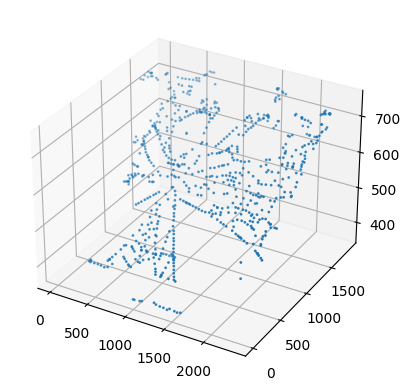

In [107]:
cgPoints = np.array([data[d].cg for d in data if data[d].contains_points])
boxNames = [data[d].name for d in data if data[d].contains_points]
nameConversion = dict(zip(boxNames, np.arange(len(boxNames))))
connections = [data[d].connections for d in data if data[d].contains_points]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(cgPoints[:,0], cgPoints[:,1], cgPoints[:,2], s=1)
plt.show()

In [108]:
np.sum(adjMat)

1386.0

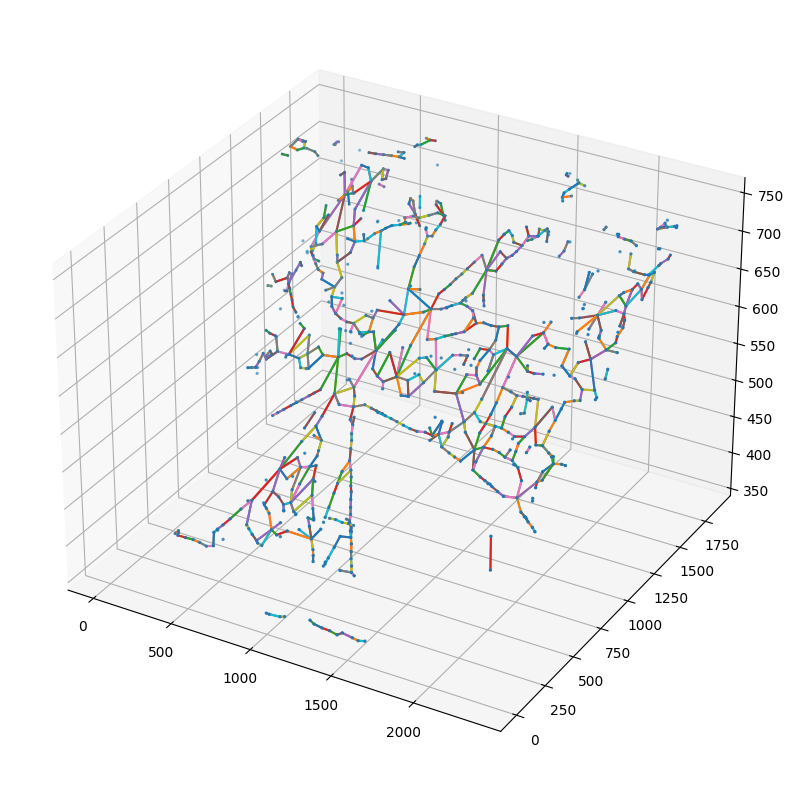

In [109]:
%matplotlib inline
adjMat = np.zeros((len(cgPoints), len(cgPoints)))

#cgField = courseGrainField(allPoints, 1, latticeSpacing=.02)

#densityPoints = np.array(np.where(cgField > .1)).T

for i in range(len(adjMat)):
    for k,v in connections[i].items():
        adjMat[i,nameConversion[k]] += 1
        
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

#ax.scatter(densityPoints[:,0], densityPoints[:,1], densityPoints[:,2], s=5, alpha=.1, c=cgField[np.where(cgField > .1)])

ax.scatter(cgPoints[:,0], cgPoints[:,1], cgPoints[:,2], s=2)
for i in range(len(adjMat)):
    edgeIndices = np.where(adjMat[i] > 0)[0]
    for j in range(len(edgeIndices)):
        ax.plot(*list(zip(cgPoints[i], cgPoints[edgeIndices[j]])))

plt.savefig('skeltre_web_t128.png', bbox_inches='tight')
plt.show()

In [23]:
graph = nx.Graph()

graph.add_nodes_from(cgPoints)

ValueError: too many values to unpack (expected 2)

In [27]:
def courseGrainField(points, values=None, defaultValue=0, latticeSpacing=None, kernel='gaussian', kernelSize=5):
    """
    Course grains a collection of values at arbitrary points,
    into a discrete field.

    If `values=None`, course-grained field is the point density. 

    Parameters
    ----------
    points : numpy.ndarray[N,d]
        Spatial positions of N points in d-dimensional space.

    values : numpy.ndarray[N,[k]] or None
        Field values at each point. Can be k-dimensional vector,
        resulting in k course-grained fields. If `None`, returned
        field will be the point density.

    defaultValue : float or numpy.ndarray[k]
        The default value of the course-grained field;
        probably `0` for most applications.

    latticeSpacing : float or None
        The spacing of lattice points for the course-grained field.

        If `None`, will be chosen such that the largest-spanning axis
        has 100 lattice points, with other axes using the same spacing.

    kernel : str or numpy.ndarray[A,A]
        The kernel to course-grain the field with. 'gaussian'
        option is implemented as default, but a custom matrix
        can be provided. If using default gaussian option,
        kernel size can be set with `kernelSize`.

    kernelSize : int
        The kernel size to use if `kernel='gaussian'`.
        If a custom kernel is provided, this has no effect.
    """

    # Calculate the bounds of the volume enclosing all of the data
    occupiedVolumeBounds = np.array(list(zip(np.min(points, axis=0), np.max(points, axis=0))))

    # Create a lattice with the selected scale for that cube
    if latticeSpacing is not None:
        spacing = latticeSpacing
    else:
        # Choose such that the largest spanning axis has 100 points
        spacing = np.max(occupiedVolumeBounds[:,1] - occupiedVolumeBounds[:,0]) / 100

    fieldDims = np.ceil(1 + (occupiedVolumeBounds[:,1] - occupiedVolumeBounds[:,0])/(spacing)).astype(np.int64)

    # Calculate which lattice cell each scatter point falls into
    latticePositions = np.floor((points - occupiedVolumeBounds[:,0])/spacing).astype(np.int64)

    # Check if an array of values was passed for each point
    # Otherwise we just have a scalar field (and we'll collapse
    # the last dimension later on).
    if hasattr(values, '__iter__'):
        k = np.shape(values)[-1]
        valArr = values
    else:
        k = 1
        valArr = np.zeros((np.shape(points)[0], 1)) + values if values else 1

    fieldArr = np.zeros((*fieldDims, k))
    # Instead of actually applying a gaussian kernel now, which would be
    # very inefficient since we'd need to sum a potentially very large number
    # of k*d dimensional matrices (more or less), we instead just assign each
    # lattice point, then smooth over it after with the specified kernel.
    # Where this might cause issues:
    # - If the lattice spacing is too large, you will get some weird artifacts
    #   from this process. Though in that case, you'll get a ton of artifacts from
    #   elsewhere too, so just don't use too large a lattice spacing :)
    print(tuple(latticePositions[0]))
    for i in range(np.shape(points)[0]):
        fieldArr[tuple(latticePositions[i])] += valArr[i]

    # Now smooth over the field
    if kernel == 'gaussian':
        gaussianBlurKernel = np.zeros(np.repeat(kernelSize, np.shape(points)[-1]))
        singleAxis = np.arange(kernelSize)
        kernelGrid = np.meshgrid(*np.repeat([singleAxis], np.shape(points)[-1], axis=0))
        #kernelGrid = np.meshgrid(singleAxis, singleAxis, singleAxis)
        # No 2 prefactor in the gaussian denominator because I want the kernel to
        # decay nearly to 0 at the corners
        kernelArr = np.exp(-np.sum([(kernelGrid[i] - (kernelSize-1)/2.)**2 for i in range(np.shape(points)[-1])], axis=0) / (kernelSize))
        # Now account for however many dimensions k we have
        #kernelArr = np.repeat([kernelArr] if k > 1 else kernelArr, k, axis=0)

    # Otherwise, we expect that kernel should already be passed as a 
    # proper square d-dimensional matrix
    else:
        kernelArr = kernel

    # Perform a convolution of the field with our kernel
    # 'same' keeps the same bounds on the field, but might cause
    # some weird effects near the boundaries
    # Divide out the sum of the kernel to normalize
    transConvolution = np.zeros_like(fieldArr.T)
        
    for i in range(k):
        # Note that convolve(x, y) == convolve(x.T, y.T).T
        # We need this so we can go over our k axis
        transConvolution[i] = convolve(fieldArr.T[i], kernelArr.T, mode='same') / np.sum(kernelArr)

    convolution = transConvolution.T

    # If k == 1, collapse the extra dimension
    if k == 1:
        return convolution[..., 0]
    
    return convolution

(33, 37, 68)


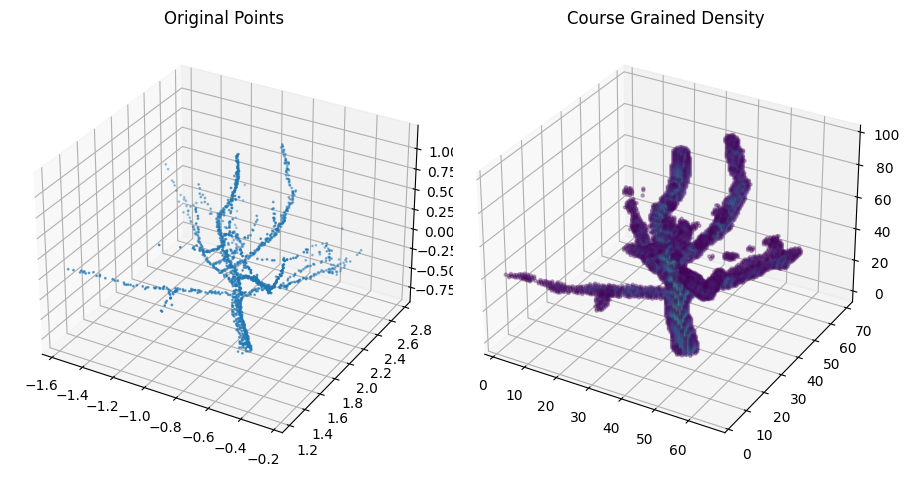

In [90]:
cgField = sk.courseGrainField(allPoints, 1, latticeSpacing=.02)

densityPoints = np.array(np.where(cgField > .05)).T

fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.scatter(allPoints[:,0], allPoints[:,1], allPoints[:,2], s=1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
scatter = ax2.scatter(densityPoints[:,0], densityPoints[:,1], densityPoints[:,2], s=5, alpha=.3, c=cgField[np.where(cgField > .05)])

ax1.set_title('Original Points')
ax2.set_title('Course Grained Density')
#fig.colorbar(scatter)

fig.tight_layout()
plt.savefig('course_grain_tree.png')
plt.show()

In [94]:
test = data[list(data.keys())[10]]
dir(test)

['Epairs',
 'Vdim',
 'Vdir',
 'Vpairs',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'calc_Vdim',
 'calc_Vdir',
 'calc_cg',
 'calc_median_distance',
 'cg',
 'check_connection_criteria',
 'children',
 'connections',
 'contains_points',
 'dict_name',
 'eat_box',
 'eat_e_pair',
 'eat_v_pair',
 'find_adjacent_super_boxes',
 'find_connections',
 'find_connections_higher_level_box',
 'find_e_pairs',
 'find_super_boxes',
 'find_v_pairs',
 'get_best_connection_to_super_box',
 'get_best_epair',
 'get_best_vpair',
 'get_box_object',
 'get_combined_dim',
 'get_directional_labels',
 'get_neighbour_names',
 'get_potential_neighbours_names',
 'get_super_box_properties',
 'get_sur

In [110]:
pd.DataFrame([vars(data[d]) for d in data])

,dict_name,name,points,use_higher_dimensional_boxes,cg,contains_points,merged,parent,children,connections,Vdim,Vdir,Vpairs,Epairs
0,myDict,Box_7_7_15,"[[-0.835007, 1.87999, 0.706009]]",False,"[-0.835007, 1.87999, 0.706009]",True,False,None,[],{},0,"[0, 0, 0]",[],[]
1,myDict,Box_10_3_10,"[[-0.525009, 1.563, 0.245987]]",False,"[-0.525009, 1.563, 0.245987]",True,False,None,[],{},0,"[0, 0, 0]",[],[]
2,myDict,Box_12_11_7,"[[-0.423996, 2.338, -0.07399]]",False,"[-0.423996, 2.338, -0.07399]",True,False,None,[],{},0,"[0, 0, 0]",[],[]
3,myDict,Box_6_8_6,"[[-0.972, 1.99699, -0.158005], [-0.974991, 2.0...",False,"[-0.9754945, 2.0272425000000003, -0.16000375]",True,False,None,[],"{'Box_6_9_6': [0, 1, 0], 'Box_6_8_7': [0, 0, 1]}",2,"[0, 1, 1]",[],[]
4,myDict,Box_12_2_11,"[[-0.423996, 1.46599, 0.341995]]",False,"[-0.423996, 1.46599, 0.341995]",True,False,None,[],{},0,"[0, 0, 0]",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,myDict,Box_6_2_8,"[[-1.00801, 1.451, -0.043015], [-0.969009, 1.3...",False,"[-0.9782071999999999, 1.3941999999999999, -0.0...",True,False,None,[],"{'Box_6_2_7': [0, 0, -1], 'Box_6_1_8': [0, -1,...",2,"[0, -1, -1]",[],[]
253,myDict,Box_10_7_15,"[[-0.543991, 1.95399, 0.649002], [-0.537003, 1...",False,"[-0.540497, 1.9505, 0.671005]",True,False,None,[],"{'Box_10_7_14': [0, 0, -1]}",1,"[0, 0, -1]",[],[]
254,myDict,Box_8_6_8,[],False,None,False,True,Box_8_5_8,[],{},0,[],[],[]
255,myDict,Box_6_3_7,"[[-1.002, 1.52699, -0.108994], [-1.01701, 1.53...",False,"[-0.9900004166666666, 1.531415, -0.09883116666...",True,False,None,[],"{'Box_5_3_7': [-1, 0, 0]}",1,"[-1, 0, 0]",[],[]


In [130]:
def partitionIntoBoxes(points, nBoxes, cubes=False, returnCorners=False):
    """
    Partition a set of points into boxes of equal size.

    Parameters
    ----------
    points : numpy.ndarray[N,d]
        Array of N points in d dimensions
        
    nBoxes : int
        Number of boxes to partition the space into; not necessarily the
        number of unique box identities returned, since only non-empty
        boxes will be returned.
        
    cubes : bool
        Whether to partition the space into isotropic volumes (True), or to
        allow the dimensions of the boxes to vary between dimensions (False).
        
    Returns
    -------
    boxSize : numpy.ndarray[d]
        Dimensions of the subdivided spaces.
        
    boxIdentities : numpy.ndarray[N]
        Identities of the box to which each point belongs to.
        Guaranteed to be continuous interger labels, ie. the
        total number of occupied boxes, M, is:
        
            `np.max(np.unique(boxIdentities)) + 1`
            
        and the existence of box `i` implies the existence
        of box `i-1` for i > 0.
        
    boxCorners : numpy.ndarray[M,d]
        Corner of each occupied box; note that M != N in most
        cases.
        
    """

    occupiedVolumeBounds = np.array(list(zip(np.min(points, axis=0), np.max(points, axis=0))))

    volumeSize = occupiedVolumeBounds[:,1] - occupiedVolumeBounds[:,0]
    print(points.shape[-1])
    boxSize = volumeSize / nBoxes**(1/points.shape[-1]) # [x, y, z, ...]

    if cubes:
        # If we are partitioning into cubes, then we have to choose the dimension of the
        # side; we choose the finest dimension, because that seems reasonable.
        boxSize = np.repeat(np.min(boxSize), points.shape[-1])
    
    boxIdentities = np.floor((points - occupiedVolumeBounds[:,0]) / boxSize).astype(np.int64)

    # Now change box identities from (i,j,k) to just i
    boxLabels = [tuple(t) for t in np.unique(boxIdentities, axis=0)] # (i,j,k)
    # dictionary: {(i,j,k) : l}
    boxLabelConversion = dict(zip(boxLabels, np.arange(len(boxLabels))))
    linearBoxIdentities = np.array([boxLabelConversion[tuple(l)] for l in boxIdentities]) # l
    
    if returnCorners:
        # Upper left corner of the boxes
        boxCorners = [tuple(occupiedVolumeBounds[:,0] + t*boxSize) for t in np.unique(boxIdentities, axis=0)]
        # Note that this conversion is slightly different than before since we
        # don't want the corner for each point, but for each box; see docstring
        boxCornersConversion = dict(zip(boxLabels, boxCorners))
        inverseLabelConversion = {v : k for k,v in boxLabelConversion.items()}
        linearBoxCorners = np.array([boxCornersConversion[inverseLabelConversion[l]] for l in np.unique(linearBoxIdentities)])
        return boxSize, linearBoxIdentities, linearBoxCorners
    
    return boxSize, linearBoxIdentities


In [142]:
boxSize, identities = partitionIntoBoxes(allPoints, 100)

3


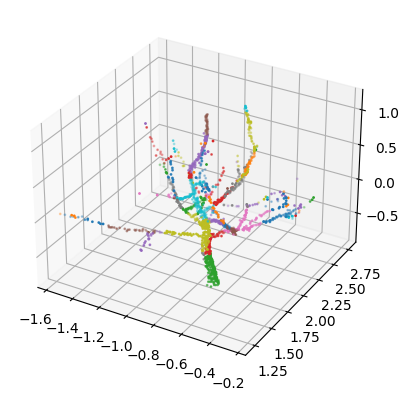

In [143]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(np.unique(identities))):
    p = np.where(identities == i)
    ax.scatter(allPoints[p,0], allPoints[p,1], allPoints[p,2], s=1)
plt.show()

In [136]:
print(centers[0])
print(allPoints[np.where(identities == 0)])

[-1.56801    1.22301   -0.0211934]
[[-1.53999   1.291     0.035995]
 [-1.56801   1.27901   0.042007]
 [-1.50401   1.30199   0.018997]
 [-1.48799   1.31001   0.022995]
 [-1.45799   1.32399   0.020004]
 [-1.442     1.347     0.018997]
 [-1.45299   1.27699   0.057999]
 [-1.451     1.25999   0.099014]
 [-1.467     1.25401   0.103989]]


In [123]:
len(centers)

1444

In [144]:
axis = np.arange(5)

In [162]:
a = np.array([[1, 2], [3, 4]])
np.repeat([a], 3, axis=0)

array([[[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]],

       [[1, 2],
        [3, 4]]])

In [60]:
a = np.random.uniform(size=(101,101))
a[25,25]=3

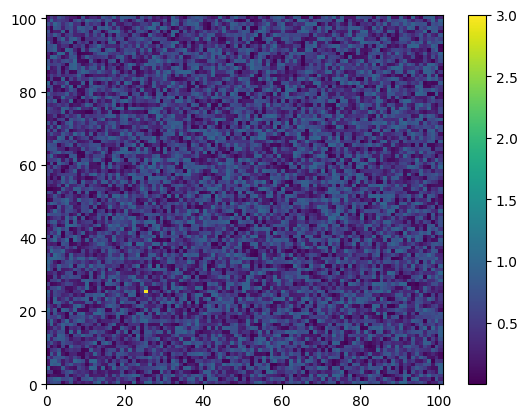

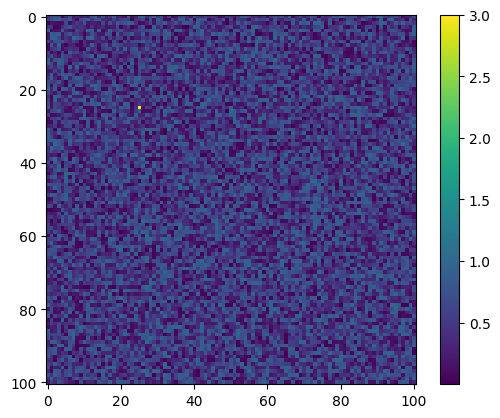

In [61]:
%matplotlib inline
plt.pcolor(a)
plt.colorbar()
plt.show()

plt.imshow(a)
plt.colorbar()
plt.show()

In [52]:
def pointsOnCirclePerimeter(r):
    yAxis = np.arange(a.shape[0])
    xAxis = np.arange(a.shape[1])
    center = np.array([50,50])

    innerCircle = np.add.outer((xAxis - center[1])**2, (yAxis - center[0])**2) <= (r-1)**2
    outerCircle = np.add.outer((xAxis - center[1])**2, (yAxis - center[0])**2) <= (r+1)**2

    circlePerimeter = innerCircle.astype(int) + outerCircle.astype(int) == 1

    return np.where(circlePerimeter)

/home/jack/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jack/anaconda3/envs/ml/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


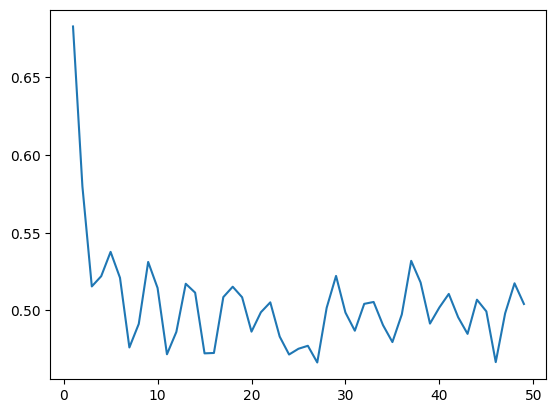

In [53]:
plt.plot(np.arange(0, 50), [np.mean(a[pointsOnCirclePerimeter(r)]) for r in range(0, 50)])
plt.show()

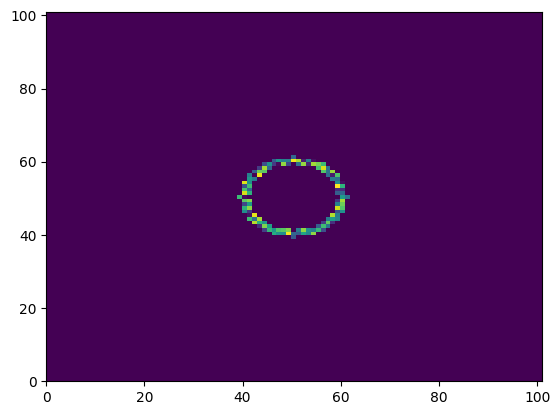

In [51]:

plt.pcolor(np.where(circlePerimeter, a, 0))
plt.show()

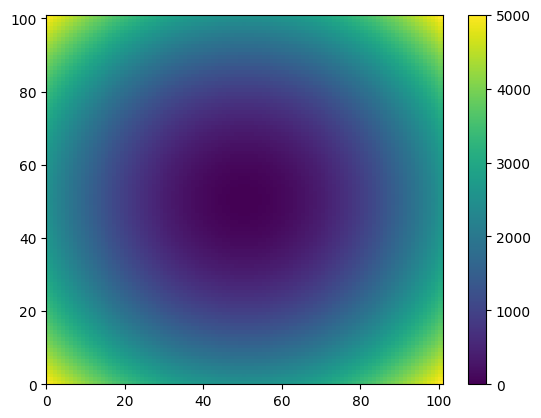

In [64]:
def circleRadii():
    yAxis = np.arange(a.shape[0])
    xAxis = np.arange(a.shape[1])
    center = np.array([50,50])

    circle = np.add.outer((xAxis - center[1])**2, (yAxis - center[0])**2)

    circlePerimeter = innerCircle.astype(int) + outerCircle.astype(int) == 1

    return circle

plt.pcolor(circleRadii())
plt.colorbar()
plt.show()

In [65]:
a = [1, 2, 3, 4]
b = (1, 2, 3, 4)
c = np.array(a) # np.array(b)

In [66]:
type(a)

list

In [67]:
type(b)

tuple

In [68]:
type(c)

numpy.ndarray